In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import metrics

np.random.seed(0)

In [2]:
data = pd.read_csv('autos.csv')
data.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [3]:
data.shape

(193, 25)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          193 non-null    int64  
 1   make               193 non-null    object 
 2   fuel_type          193 non-null    object 
 3   aspiration         193 non-null    object 
 4   num_of_doors       193 non-null    int64  
 5   body_style         193 non-null    object 
 6   drive_wheels       193 non-null    object 
 7   engine_location    193 non-null    object 
 8   wheel_base         193 non-null    float64
 9   length             193 non-null    float64
 10  width              193 non-null    float64
 11  height             193 non-null    float64
 12  curb_weight        193 non-null    int64  
 13  engine_type        193 non-null    object 
 14  num_of_cylinders   193 non-null    int64  
 15  engine_size        193 non-null    int64  
 16  fuel_system        193 non

In [5]:
data.isnull().sum()

symboling            0
make                 0
fuel_type            0
aspiration           0
num_of_doors         0
body_style           0
drive_wheels         0
engine_location      0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_type          0
num_of_cylinders     0
engine_size          0
fuel_system          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

In [6]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
data[cat_cols].head()

,make,fuel_type,aspiration,body_style,drive_wheels,engine_location,engine_type,fuel_system
0,alfa-romero,gas,std,convertible,rwd,front,dohc,mpfi
1,alfa-romero,gas,std,convertible,rwd,front,dohc,mpfi
2,alfa-romero,gas,std,hatchback,rwd,front,ohcv,mpfi
3,audi,gas,std,sedan,fwd,front,ohc,mpfi
4,audi,gas,std,sedan,4wd,front,ohc,mpfi


Inspecting the cardinality

In [7]:
data[cat_cols].nunique()

make               21
fuel_type           2
aspiration          2
body_style          5
drive_wheels        3
engine_location     2
engine_type         5
fuel_system         7
dtype: int64

Inspecting data consistency and entry errors

In [8]:
# def count_cats(df):
#     entries = {}
#     for col in df.columns:
#         entries[col] = df[col].unique()
#     return entries

def count_cats(df):
    entries = {col: df[col].unique() for col in df.columns}
    return entries

In [9]:
count_cats(data[cat_cols])

{'make': array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
        'isuzu', 'jaguar', 'mazda', 'mercedes-benz', 'mercury',
        'mitsubishi', 'nissan', 'peugot', 'plymouth', 'porsche', 'saab',
        'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object),
 'fuel_type': array(['gas', 'diesel'], dtype=object),
 'aspiration': array(['std', 'turbo'], dtype=object),
 'body_style': array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
       dtype=object),
 'drive_wheels': array(['rwd', 'fwd', '4wd'], dtype=object),
 'engine_location': array(['front', 'rear'], dtype=object),
 'engine_type': array(['dohc', 'ohcv', 'ohc', 'l', 'ohcf'], dtype=object),
 'fuel_system': array(['mpfi', '2bbl', 'mfi', '1bbl', 'spfi', 'idi', 'spdi'], dtype=object)}

In [10]:
data['make'].value_counts()

toyota           32
nissan           18
honda            13
mitsubishi       13
subaru           12
mazda            12
volkswagen       12
volvo            11
peugot           11
dodge             8
bmw               8
mercedes-benz     8
plymouth          7
saab              6
audi              6
porsche           4
jaguar            3
alfa-romero       3
chevrolet         3
isuzu             2
mercury           1
Name: make, dtype: int64

Separating the features and the target

In [11]:
X = data.drop('price', axis = 1)
y = data.price

In [12]:
encoder = LabelEncoder()

In [13]:
X = X.join(X[cat_cols].apply(encoder.fit_transform).add_suffix('_label'))

X.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,city_mpg,highway_mpg,make_label,fuel_type_label,aspiration_label,body_style_label,drive_wheels_label,engine_location_label,engine_type_label,fuel_system_label
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,21,27,0,1,0,0,2,0,0,4
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,21,27,0,1,0,0,2,0,0,4
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,19,26,0,1,0,2,2,0,4,4
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,24,30,1,1,0,3,1,0,2,4
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,18,22,1,1,0,3,0,0,2,4


In [14]:
X = X.drop(cat_cols, axis = 1)
X.head()

,symboling,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,...,city_mpg,highway_mpg,make_label,fuel_type_label,aspiration_label,body_style_label,drive_wheels_label,engine_location_label,engine_type_label,fuel_system_label
0,3,2,88.6,168.8,64.1,48.8,2548,4,130,3.47,...,21,27,0,1,0,0,2,0,0,4
1,3,2,88.6,168.8,64.1,48.8,2548,4,130,3.47,...,21,27,0,1,0,0,2,0,0,4
2,1,2,94.5,171.2,65.5,52.4,2823,6,152,2.68,...,19,26,0,1,0,2,2,0,4,4
3,2,4,99.8,176.6,66.2,54.3,2337,4,109,3.19,...,24,30,1,1,0,3,1,0,2,4
4,2,4,99.4,176.6,66.4,54.3,2824,5,136,3.19,...,18,22,1,1,0,3,0,0,2,4


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.23, random_state=0)

+ ### Without Scaling

DecisionTree

In [16]:
model_dt = DecisionTreeRegressor(random_state = 11)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=11)

In [17]:
preds_dt = model_dt.predict(X_valid)
mae = metrics.mean_absolute_error(preds_dt, y_valid)
print(f'MAE: {mae}')

MAE: 1631.3333333333333


RandomForest

In [18]:
model_rf = RandomForestRegressor(random_state = 11)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=11)

In [19]:
preds_rf = model_rf.predict(X_valid)
mae = metrics.mean_absolute_error(preds_rf, y_valid)
print(f'MAE: {mae}')

MAE: 1160.0818333333332


KNeighbors

In [20]:
model_knn = KNeighborsRegressor()
model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [21]:
preds_knn = model_knn.predict(X_valid)
mae = metrics.mean_absolute_error(preds_knn, y_valid)
print(f'MAE: {mae}')

MAE: 1931.031111111111


SupportVector

In [22]:
model_svr = SVR()
model_svr.fit(X_train, y_train)

SVR()

In [23]:
preds_svr = model_svr.predict(X_valid)
mae = metrics.mean_absolute_error(preds_svr, y_valid)
print(f'MAE: {mae}')

MAE: 4757.036140561852


XGBoost

In [24]:
xgb = XGBRegressor()

In [25]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
preds_xgb = xgb.predict(X_valid)
mae = metrics.mean_absolute_error(preds_xgb, y_valid)
print(f'MAE: {mae}')

MAE: 1266.8962022569444


C:\Users\HP\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Deep Neural Network

In [27]:
X_train.shape

(148, 24)

In [28]:
model = keras.Sequential([
    layers.Dense(24, activation = 'relu', input_shape = [24]),
    layers.Dense(24, activation = 'relu'),
    layers.Dense(24, activation = 'relu'),
    layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mae')

In [29]:
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.01, 
    patience = 10,
    restore_best_weights = True
)

In [30]:
model_data = model.fit(X_train, y_train,
                      validation_data = (X_valid, y_valid),
                      batch_size = 28,
                      epochs = 500,
                      callbacks = [early_stopping]
                      )

Epoch 1/500
6/6 [==============================] - 0s 60ms/step - loss: 13112.7979 - val_loss: 12032.9248
Epoch 2/500
6/6 [==============================] - 0s 7ms/step - loss: 12824.2422 - val_loss: 11729.4893
Epoch 3/500
6/6 [==============================] - 0s 7ms/step - loss: 12510.1406 - val_loss: 11365.2109
Epoch 4/500
6/6 [==============================] - 0s 7ms/step - loss: 12126.0908 - val_loss: 10918.1455
Epoch 5/500
6/6 [==============================] - 0s 8ms/step - loss: 11653.1572 - val_loss: 10367.9746
Epoch 6/500
6/6 [==============================] - 0s 8ms/step - loss: 11069.2246 - val_loss: 9677.3486
Epoch 7/500
6/6 [==============================] - 0s 7ms/step - loss: 10338.6445 - val_loss: 8828.1543
Epoch 8/500
6/6 [==============================] - 0s 8ms/step - loss: 9452.8613 - val_loss: 7788.9888
Epoch 9/500
6/6 [==============================] - 0s 8ms/step - loss: 8368.8252 - val_loss: 6563.6709
Epoch 10/500
6/6 [==============================] - 0s 7ms/s

6/6 [==============================] - 0s 7ms/step - loss: 3097.6499 - val_loss: 2675.8237
Epoch 80/500
6/6 [==============================] - 0s 7ms/step - loss: 3042.8386 - val_loss: 2576.5176
Epoch 81/500
6/6 [==============================] - 0s 8ms/step - loss: 3037.2986 - val_loss: 2563.7427
Epoch 82/500
6/6 [==============================] - 0s 8ms/step - loss: 3066.0281 - val_loss: 2554.3408
Epoch 83/500
6/6 [==============================] - 0s 7ms/step - loss: 3013.9355 - val_loss: 2577.2476
Epoch 84/500
6/6 [==============================] - 0s 8ms/step - loss: 3024.9719 - val_loss: 2567.4607
Epoch 85/500
6/6 [==============================] - 0s 7ms/step - loss: 3031.8665 - val_loss: 2522.0815
Epoch 86/500
6/6 [==============================] - 0s 8ms/step - loss: 3035.7820 - val_loss: 2604.5317
Epoch 87/500
6/6 [==============================] - 0s 8ms/step - loss: 2973.6729 - val_loss: 2505.7407
Epoch 88/500
6/6 [==============================] - 0s 7ms/step - loss: 2997.

6/6 [==============================] - 0s 8ms/step - loss: 2693.5854 - val_loss: 2348.4800
Epoch 158/500
6/6 [==============================] - 0s 8ms/step - loss: 2784.5945 - val_loss: 2293.9375
Epoch 159/500
6/6 [==============================] - 0s 8ms/step - loss: 2683.3086 - val_loss: 2243.3940
Epoch 160/500
6/6 [==============================] - 0s 8ms/step - loss: 2718.9761 - val_loss: 2247.6465
Epoch 161/500
6/6 [==============================] - 0s 8ms/step - loss: 2686.7134 - val_loss: 2288.2097
Epoch 162/500
6/6 [==============================] - 0s 9ms/step - loss: 2722.3909 - val_loss: 2239.1980
Epoch 163/500
6/6 [==============================] - 0s 9ms/step - loss: 2687.8518 - val_loss: 2236.9004
Epoch 164/500
6/6 [==============================] - 0s 10ms/step - loss: 2696.1216 - val_loss: 2288.0513
Epoch 165/500
6/6 [==============================] - 0s 8ms/step - loss: 2851.9978 - val_loss: 2426.9131
Epoch 166/500
6/6 [==============================] - 0s 9ms/step - l

6/6 [==============================] - 0s 8ms/step - loss: 2657.2070 - val_loss: 2149.2925
Epoch 236/500
6/6 [==============================] - 0s 9ms/step - loss: 2635.6584 - val_loss: 2148.3564
Epoch 237/500
6/6 [==============================] - 0s 8ms/step - loss: 2640.3174 - val_loss: 2149.9368
Epoch 238/500
6/6 [==============================] - 0s 7ms/step - loss: 2643.5972 - val_loss: 2160.8618
Epoch 239/500
6/6 [==============================] - 0s 7ms/step - loss: 2638.6472 - val_loss: 2146.5452
Epoch 240/500
6/6 [==============================] - 0s 7ms/step - loss: 2639.3855 - val_loss: 2148.5105
Epoch 241/500
6/6 [==============================] - 0s 7ms/step - loss: 2626.9473 - val_loss: 2144.6782
Epoch 242/500
6/6 [==============================] - 0s 7ms/step - loss: 2633.2578 - val_loss: 2145.5159
Epoch 243/500
6/6 [==============================] - 0s 8ms/step - loss: 2649.2463 - val_loss: 2145.1746
Epoch 244/500
6/6 [==============================] - 0s 8ms/step - lo

6/6 [==============================] - 0s 8ms/step - loss: 2649.4434 - val_loss: 2083.4521
Epoch 314/500
6/6 [==============================] - 0s 6ms/step - loss: 2632.3367 - val_loss: 2084.0283
Epoch 315/500
6/6 [==============================] - 0s 8ms/step - loss: 2593.7610 - val_loss: 2109.9822
Epoch 316/500
6/6 [==============================] - 0s 7ms/step - loss: 2679.4365 - val_loss: 2112.6423
Epoch 317/500
6/6 [==============================] - 0s 7ms/step - loss: 2616.4746 - val_loss: 2090.4731
Epoch 318/500
6/6 [==============================] - 0s 7ms/step - loss: 2662.8411 - val_loss: 2075.9202
Epoch 319/500
6/6 [==============================] - 0s 7ms/step - loss: 2620.6572 - val_loss: 2097.7864
Epoch 320/500
6/6 [==============================] - 0s 7ms/step - loss: 2606.3652 - val_loss: 2073.8569
Epoch 321/500
6/6 [==============================] - 0s 7ms/step - loss: 2608.1157 - val_loss: 2070.7012
Epoch 322/500
6/6 [==============================] - 0s 8ms/step - lo

In [31]:
model_hist = model_data.history

model_hist = pd.DataFrame(model_hist)
model_hist.head()

,loss,val_loss
0,13112.797852,12032.924805
1,12824.242188,11729.489258
2,12510.140625,11365.210938
3,12126.090820,10918.145508
4,11653.157227,10367.974609


<AxesSubplot:>

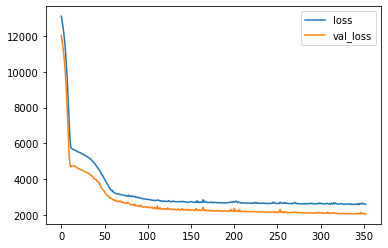

In [32]:
model_hist.plot()